# **Offensive Or Slang Word Detection**

**Environment for the Model**

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:14 http://security.ubuntu.c

**Creating Spark Session**

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[1]").appName("Slang Language Detection system").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark

**Importing Necessary Libraries**

In [3]:
import sklearn 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier


**Reading The Data**

In [73]:
dataframe = spark.read.csv("/content/dataset_bid data - Sheet6.csv",header=True, inferSchema=True)
dataframe.show(5)

+----------+-----+
|     Words|label|
+----------+-----+
|     Kutta|    1|
|  Bodmaish|    1|
|     Idiot|    1|
|   Rubbish|    1|
|Mair khabi|    1|
+----------+-----+
only showing top 5 rows



**Data Exploration**

In [5]:
df = dataframe.toPandas()

In [6]:
df.head(5)

,Words,label
0,Kutta,1
1,Bodmaish,1
2,Idiot,1
3,Rubbish,1
4,Mair khabi,1


In [74]:
dataframe.count()

3880

In [75]:
print(dataframe.filter((dataframe['label'])=='1').count())
print(dataframe.filter((dataframe['label'])=='0').count())

1958
1922


In [63]:
dataframe.dtypes

[('Words', 'string'), ('label', 'int')]

In [11]:
dataframe.printSchema()

root
 |-- Words: string (nullable = true)
 |-- label: integer (nullable = true)



**Data Preprocessing**

In [76]:
tokenizer = Tokenizer(inputCol="Words", outputCol="token")
tokenData = tokenizer.transform(dataframe)
tokenData.show(truncate=False, n=5)

+----------+-----+-------------+
|Words     |label|token        |
+----------+-----+-------------+
|Kutta     |1    |[kutta]      |
|Bodmaish  |1    |[bodmaish]   |
|Idiot     |1    |[idiot]      |
|Rubbish   |1    |[rubbish]    |
|Mair khabi|1    |[mair, khabi]|
+----------+-----+-------------+
only showing top 5 rows



In [77]:
hashTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="feature")
Data = hashTF.transform(tokenData).select("Words", "feature", "label")
Data.show(truncate=False, n=5)

+----------+----------------------------------+-----+
|Words     |feature                           |label|
+----------+----------------------------------+-----+
|Kutta     |(262144,[144751],[1.0])           |1    |
|Bodmaish  |(262144,[7931],[1.0])             |1    |
|Idiot     |(262144,[80216],[1.0])            |1    |
|Rubbish   |(262144,[216381],[1.0])           |1    |
|Mair khabi|(262144,[233520,258457],[1.0,1.0])|1    |
+----------+----------------------------------+-----+
only showing top 5 rows



In [14]:
Data.describe().show()

+-------+--------------+------------------+
|summary|         Words|             label|
+-------+--------------+------------------+
|  count|          1870|              1870|
|   mean|          null|0.5021390374331551|
| stddev|          null|0.5001291667564349|
|    min| mittuk mohila|                 0|
|    max|       zindegi|                 1|
+-------+--------------+------------------+



**Converting String Data into Numerical Feature Using StringIndexer(Data Preprocessing)**

In [30]:
#indexer = StringIndexer(inputCol='Words',outputCol='feature')
#new_dataframe = indexer.fit(dataframe).transform(dataframe)
#new_dataframe.show(10)

+------------+-----+-------+
|       Words|label|feature|
+------------+-----+-------+
|       Kutta|    1|   59.0|
|    Bodmaish|    1|   55.0|
|       Idiot|    1|   58.0|
|     Rubbish|    1|   61.0|
|  Mair khabi|    1|   60.0|
|ei bokachoda|    1|  251.0|
|    bainchod|    1|    4.0|
|khankir pola|    1|  407.0|
|  motherchod|    1|   27.0|
| amre chinos|    1|   85.0|
+------------+-----+-------+
only showing top 10 rows



In [31]:
#onehotencoder_vector = OneHotEncoder(inputCol="feature", outputCol="feature_vec")
#df = onehotencoder_vector.fit(new_dataframe).transform(new_dataframe)
#df.show()

+---------------+-----+-------+-----------------+
|          Words|label|feature|      feature_vec|
+---------------+-----+-------+-----------------+
|          Kutta|    1|   59.0| (995,[59],[1.0])|
|       Bodmaish|    1|   55.0| (995,[55],[1.0])|
|          Idiot|    1|   58.0| (995,[58],[1.0])|
|        Rubbish|    1|   61.0| (995,[61],[1.0])|
|     Mair khabi|    1|   60.0| (995,[60],[1.0])|
|   ei bokachoda|    1|  251.0|(995,[251],[1.0])|
|       bainchod|    1|    4.0|  (995,[4],[1.0])|
|   khankir pola|    1|  407.0|(995,[407],[1.0])|
|     motherchod|    1|   27.0| (995,[27],[1.0])|
|    amre chinos|    1|   85.0| (995,[85],[1.0])|
|     jutar bari|    1|  396.0|(995,[396],[1.0])|
|    you are hot|    1|  771.0|(995,[771],[1.0])|
|        shoytan|    1|  663.0|(995,[663],[1.0])|
|  kelani chinos|    1|  405.0|(995,[405],[1.0])|
|          laura|    1|  436.0|(995,[436],[1.0])|
|            bal|    1|   39.0| (995,[39],[1.0])|
|  tui ay khali |    1|  724.0|(995,[724],[1.0])|


In [36]:
#inputCol=['feature_vec']
#assembler = (VectorAssembler()).setInputCols(inputCol).setOutputCol("features")
#value = assembler.transform(df)
#value.show(5)

+----------+-----+-------+----------------+----------------+
|     Words|label|feature|     feature_vec|        features|
+----------+-----+-------+----------------+----------------+
|     Kutta|    1|   59.0|(995,[59],[1.0])|(995,[59],[1.0])|
|  Bodmaish|    1|   55.0|(995,[55],[1.0])|(995,[55],[1.0])|
|     Idiot|    1|   58.0|(995,[58],[1.0])|(995,[58],[1.0])|
|   Rubbish|    1|   61.0|(995,[61],[1.0])|(995,[61],[1.0])|
|Mair khabi|    1|   60.0|(995,[60],[1.0])|(995,[60],[1.0])|
+----------+-----+-------+----------------+----------------+
only showing top 5 rows



**Train Test Split**

In [78]:
train_data, test_data = Data.randomSplit([0.7, 0.3])

In [79]:
print("Train Data = ",train_data.count())
print("Test Data = ",test_data.count())

Train Data =  2711
Test Data =  1169


**Logistic Regression**

In [80]:
lr = LogisticRegression(labelCol='label', featuresCol='feature', maxIter=10, regParam=0.01)
logistic_model = lr.fit(train_data)
print("Training is done!!!")

Training is done!!!


In [81]:
logistic_transform = logistic_model.transform(test_data)
logistic_predictions = logistic_transform.select('Words','label','prediction')
pandas_df = logistic_predictions.toPandas()
pandas_df.sample(5)

,Words,label,prediction
972,shaheb,0,0.0
639,likeable,0,0.0
679,madhoshiyan,0,0.0
1094,ugro,1,0.0
775,nonsense,1,1.0


**Accuracy Score**

In [106]:
y_true = logistic_predictions.select(['label']).collect()
y_pred = logistic_predictions.select(['prediction']).collect()

cf_matrix = confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       574
           1       1.00      0.97      0.98       595

    accuracy                           0.98      1169
   macro avg       0.98      0.98      0.98      1169
weighted avg       0.99      0.98      0.98      1169



**Decision Tree Classification**

In [95]:
dc = DecisionTreeClassifier(featuresCol='feature',labelCol='label')
decision_tree_model=dc.fit(train_data)

In [96]:
decision_tree_transform = decision_tree_model.transform(test_data)
dc_predictions = decision_tree_transform.select('Words','label','prediction')
pandas_df = dc_predictions.toPandas()
pandas_df.sample(5)

,Words,label,prediction
798,oshobbo,1,0.0
238,chol pat khete jai,1,0.0
1020,sophisticated,0,0.0
880,public property,1,0.0
291,dhongsho,0,0.0


**Accuracy Score**

In [99]:
y_true = dc_predictions.select(['label']).collect()
y_pred = dc_predictions.select(['prediction']).collect()

cf_matrix = confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       574
           1       1.00      0.05      0.09       595

    accuracy                           0.51      1169
   macro avg       0.75      0.52      0.38      1169
weighted avg       0.76      0.51      0.37      1169



**Random Forest Classifier**

In [100]:
rfc = RandomForestClassifier(featuresCol="feature", labelCol="label")
rfc_model = rfc.fit(train_data)

In [101]:
rfc_transform = rfc_model.transform(test_data)
rfc_predictions = rfc_transform.select('Words','label','prediction')
pandas_df = dc_predictions.toPandas()
pandas_df.sample(5)

,Words,label,prediction
23,abal,1,0.0
7,Idiot,1,0.0
228,chenchra,1,0.0
290,dhemni,1,0.0
794,onek shorol,0,0.0


**Accuracy Score**

In [104]:
y_true = rfc_predictions.select(['label']).collect()
y_pred = rfc_predictions.select(['prediction']).collect()

cf_matrix = confusion_matrix(y_true, y_pred)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.05      0.09       574
           1       0.52      1.00      0.68       595

    accuracy                           0.53      1169
   macro avg       0.74      0.52      0.39      1169
weighted avg       0.74      0.53      0.39      1169



**Plotting Confusion Matrix**

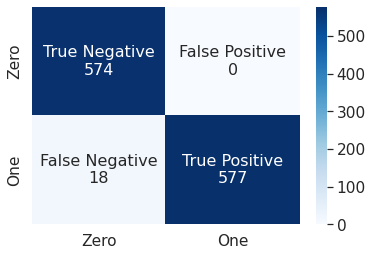

In [107]:
matrix = pd.DataFrame(cf_matrix, index = [i for i in ['Zero', 'One']],columns = [i for i in ['Zero', 'One']])

name = ['True Negative','False Positive','False Negative','True Positive']
count = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in zip(name,count)]
labels = np.asarray(labels).reshape(2,2)

sns.set(font_scale=1.4) # for label size
sns.heatmap(matrix, annot=labels, fmt='',annot_kws={"size": 16}, cbar=True, cmap='Blues')

plt.show()